
#**Stock Market Indexes Predictions**

#Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
# !pip install pystan~=2.14
# !pip install fbprophet
# warnings.filterwarnings('ignore')
# import fbprophet
# # print version number
# print('Prophet %s' % fbprophet.__version__)
# from matplotlib import pyplot
# from fbprophet import Prophet
from prophet import Prophet
import holidays


#NIfty 50

In [388]:
#Reading Nifty File
df_Nifty = pd.read_csv('/content/NIFTY50.csv')
df_Nifty["date_clean"] = df_Nifty["Date"].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y').date() )
df_Nifty['year']=df_Nifty['date_clean'].apply(lambda x: x.year)
df_Nifty['Month']=df_Nifty['date_clean'].apply(lambda x: x.month)
df_Nifty['day']=df_Nifty['date_clean'].apply(lambda x: x.day)
#df_Nifty=df_Nifty[(df_Nifty['year']>=2020)]
df_Nifty=df_Nifty[((df_Nifty['year']==2021)&(df_Nifty['Month']>6))|((df_Nifty['year']==2022)&(df_Nifty['Month']>=1))]
df_Nifty.head()

,Date,Open,High,Low,Close,Adj Close,Volume,date_clean,year,Month,day
615,01-07-2021,15755.05,15755.55,15667.05,15680.00,15680.00,224900.0,2021-07-01,2021,7,1
616,02-07-2021,15705.85,15738.35,15635.95,15722.20,15722.20,254800.0,2021-07-02,2021,7,2
617,05-07-2021,15793.40,15845.95,15762.05,15834.35,15834.35,207000.0,2021-07-05,2021,7,5
618,06-07-2021,15813.75,15914.20,15801.00,15818.25,15818.25,391400.0,2021-07-06,2021,7,6
619,07-07-2021,15819.60,15893.55,15779.70,15879.65,15879.65,329300.0,2021-07-07,2021,7,7


##EDA

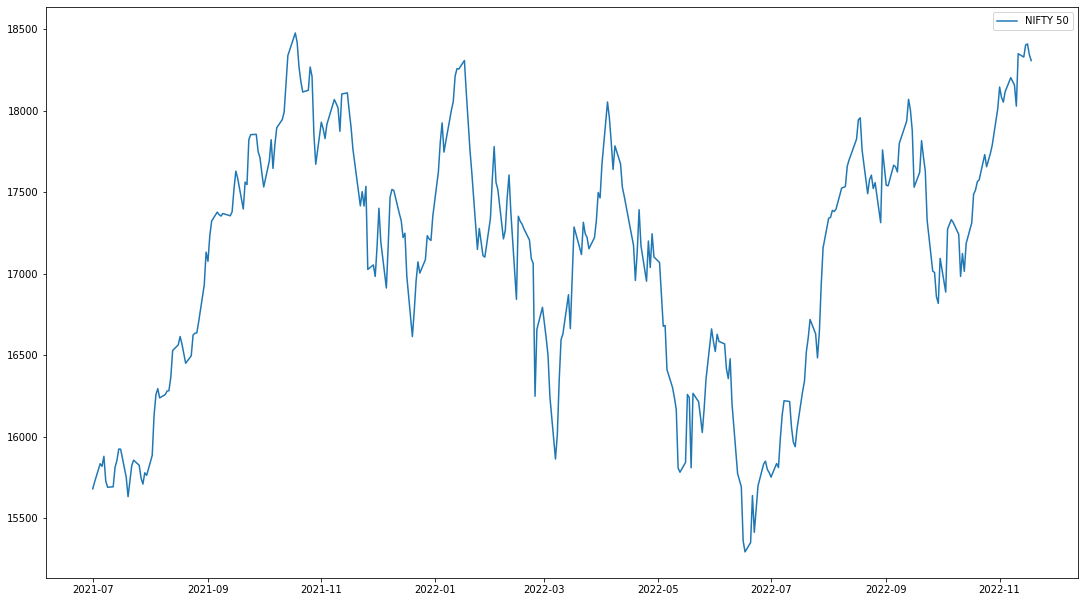

In [389]:
from matplotlib import pyplot
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
pyplot.plot(df_Nifty['date_clean'],df_Nifty["Close"], label='NIFTY 50')
pyplot.legend()
pyplot.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/6phpavsx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/5x_kpnm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2338', 'data', 'file=/tmp/tmp9puoo3fo/6phpavsx.json', 'init=/tmp/tmp9puoo3fo/5x_kpnm_.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_modelkxfxbb4f/prophet_model-20221120134107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:C

MAE: 35.581
MAPE: 0.194
MAE_NIFTY =  35.58099846776749
MAPE_NIFTY =  0.19397875309095514
RMSE_NIFTY =  39.05617325875561
          ds          yhat    yhat_lower    yhat_upper
0 2022-11-14  18277.285732  17139.133699  19442.066715
1 2022-11-15  18377.798420  17212.634694  19471.542154
2 2022-11-16  18418.633537  17279.886436  19606.519411
3 2022-11-17  18392.694737  17209.840441  19631.196204
4 2022-11-18  18350.310871  17237.591832  19468.136990
           ds         y
0  2022-11-14  18329.15
1  2022-11-15  18403.40
2  2022-11-16  18409.65
3  2022-11-17  18343.90
4  2022-11-18  18307.65


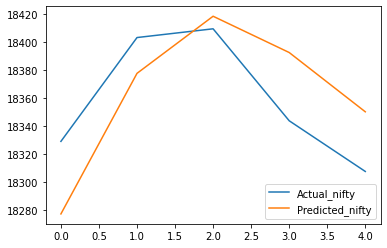

In [390]:
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_Nifty=preprocessing(df_Nifty)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100    
def ProhetModel(DF,CountryName):
  #train test split
  df2_test=DF[-5:]
  df2_train=DF[:-5]
  test_val = df2_test.copy()
  train_val = df2_train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.009,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 2,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=10,
                      daily_seasonality = False,
                      #yearly_seasonality = 5,
                      interval_width=0.95)
  final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=4, mode='additive')
  #final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5,mode='additive')
  #final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  forecast = final_model.predict(test_val.drop("y", axis=1))
  mae = mean_absolute_error(test_val["y"], list(forecast["yhat"]))
  print('MAE: %.3f' % mae)
  mape = mean_absolute_percentage_error(test_val["y"], list(forecast["yhat"]))
  print('MAPE: %.3f' % mape)
  se = np.square(test_val["y"] -list(forecast["yhat"]))
  mse = np.mean(se)
  rmse = np.sqrt(mse)
  return mae, mape, forecast , test_val,rmse,train_val

mae_nifty, mape_nifty, forecast_nifty,test_val_nifty,rmse_nifty,train_val_nifty = ProhetModel(DF_Nifty,'India')
print('MAE_NIFTY = ',mae_nifty)
print('MAPE_NIFTY = ', mape_nifty)
print('RMSE_NIFTY = ',rmse_nifty)
print(forecast_nifty[['ds','yhat','yhat_lower','yhat_upper']])
print(test_val_nifty)

from matplotlib import pyplot
pyplot.plot(test_val_nifty["y"], label='Actual_nifty')
pyplot.plot(list(forecast_nifty["yhat"]), label='Predicted_nifty')
pyplot.legend()
pyplot.show()



#testing loops

In [391]:
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_Nifty=preprocessing(df_Nifty)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100    


##Predicting for 21st Oct to 25th Nov

In [392]:
import dateutil
future = []
for i in range(3,8,1):
  future.append(DF_Nifty["ds"][DF_Nifty.shape[0]-1] + dateutil.relativedelta.relativedelta(days=i))
  
test_nifty = pd.DataFrame({"ds":future})
test_nifty = test_nifty.reset_index(drop=True)
print(test_nifty)

           ds
0  2022-11-21
1  2022-11-22
2  2022-11-23
3  2022-11-24
4  2022-11-25


In [394]:
def ProhetModel_test_nifty(test,train,CountryName):
  #train test split
  test_val = test.copy()
  train_val = train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.009,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 2,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=10,
                      daily_seasonality = False,
                      #yearly_seasonality = 5,
                      interval_width=0.95)
  final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=4, mode='additive')
  #final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5,mode='additive')
  #final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  forecast = final_model.predict(test_val)
  a=final_model.train_holiday_names.to_list()
  return forecast , test_val,train_val

train_nifty=DF_Nifty.copy()
final_forecast_nifty,final_test_val_nifty,final_train_val_nifty = ProhetModel_test_nifty(test_nifty,train_nifty,'India')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/8olh95ve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/9f56ttem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65235', 'data', 'file=/tmp/tmp9puoo3fo/8olh95ve.json', 'init=/tmp/tmp9puoo3fo/9f56ttem.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_modelbx0vqih_/prophet_model-20221120134129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:

In [395]:
print(final_forecast_nifty[['ds','yhat','yhat_lower','yhat_upper']])

          ds          yhat    yhat_lower    yhat_upper
0 2022-11-21  18299.014561  17115.637728  19518.023350
1 2022-11-22  18377.627620  17161.071690  19618.496775
2 2022-11-23  18407.555434  17166.323913  19565.507564
3 2022-11-24  18382.413941  16998.169038  19544.338790
4 2022-11-25  18334.004754  17261.725373  19544.577826


#FTSE 100

In [376]:
#Reading FTSE File
df_FTSE = pd.read_csv('/content/FTSE 100.csv')
df_FTSE["date_clean"] = df_FTSE["Date"].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y').date() )
df_FTSE['year']=df_FTSE['date_clean'].apply(lambda x: x.year)
df_FTSE['Month']=df_FTSE['date_clean'].apply(lambda x: x.month)
df_FTSE['day']=df_FTSE['date_clean'].apply(lambda x: x.day)
#df_FTSE=df_FTSE[df_FTSE['year'].isin([2021,2022])]
df_FTSE=df_FTSE[((df_FTSE['year']==2021)&(df_FTSE['Month']>=1))|((df_FTSE['year']==2022)&(df_FTSE['Month']>=1))]
df_FTSE.head()

,Date,Close,Open,High,Low,Volume,Chg%,date_clean,year,Month,day
0,18-11-2022,7385.52,NaN,NaN,NaN,NaN,NaN,2022-11-18,2022,11,18
1,17-11-2022,7346.54,NaN,NaN,NaN,NaN,NaN,2022-11-17,2022,11,17
2,16-11-2022,7351.19,NaN,NaN,NaN,NaN,NaN,2022-11-16,2022,11,16
3,15-11-2022,7369.44,NaN,NaN,NaN,NaN,NaN,2022-11-15,2022,11,15
4,14-11-2022,7385.17,NaN,NaN,NaN,NaN,NaN,2022-11-14,2022,11,14


#EDA

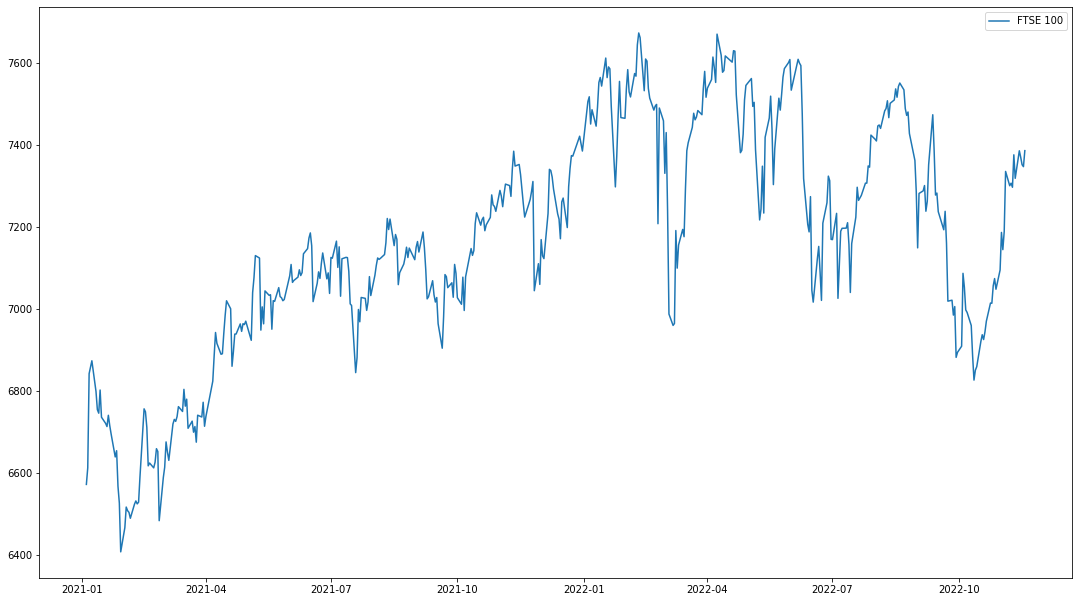

In [377]:
from matplotlib import pyplot
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
pyplot.plot(df_FTSE['date_clean'],df_FTSE["Close"], label='FTSE 100')
pyplot.legend()
pyplot.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/cusr8rix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/b34pj7yq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33038', 'data', 'file=/tmp/tmp9puoo3fo/cusr8rix.json', 'init=/tmp/tmp9puoo3fo/b34pj7yq.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_modele9wyy5ac/prophet_model-20221120133830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:38:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 25.050
MAPE: 0.340
MAE_ftse =  25.050417109569025
MAPE_ftse =  0.33975673492170333
RMSE_ftse =  27.843986951419595
          ds         yhat   yhat_lower   yhat_upper
0 2022-11-14  7345.445940  7159.803447  7530.194008
1 2022-11-15  7359.222715  7165.318058  7551.775268
2 2022-11-16  7377.502255  7199.144106  7555.920267
3 2022-11-17  7358.765620  7178.117291  7546.892152
4 2022-11-18  7348.747134  7162.916099  7534.249042
           ds        y
0  2022-11-14  7385.17
1  2022-11-15  7369.44
2  2022-11-16  7351.19
3  2022-11-17  7346.54
4  2022-11-18  7385.52


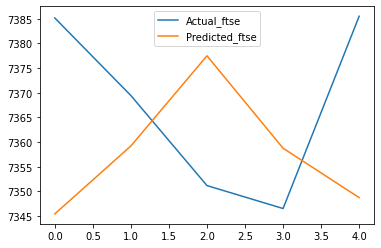

In [378]:
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_FTSE=preprocessing(df_FTSE)    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def ProhetModel(DF,CountryName):
  #train test split
  df2_test=DF[-5:]
  df2_train=DF[:-5]
  test_val = df2_test.copy()
  train_val = df2_train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.03,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 2,
                      seasonality_mode = 'additive',
                      weekly_seasonality=40,
                      daily_seasonality = False,
                      yearly_seasonality = 10,
                      #quarterly_seasonality = True,
                      interval_width=0.95)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  #final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  forecast = final_model.predict(test_val.drop("y", axis=1))
  mae = mean_absolute_error(test_val["y"], list(forecast["yhat"]))
  print('MAE: %.3f' % mae)
  mape = mean_absolute_percentage_error(test_val["y"], list(forecast["yhat"]))
  print('MAPE: %.3f' % mape)
  se = np.square(test_val["y"] -list(forecast["yhat"]))
  mse = np.mean(se)
  rmse = np.sqrt(mse)
  return mae, mape, forecast , test_val,rmse,train_val

mae_ftse, mape_ftse, forecast_ftse,test_val_FTSE,rmse_ftse,train_val_ftse = ProhetModel(DF_FTSE,'UK')
print('MAE_ftse = ',mae_ftse)
print('MAPE_ftse = ', mape_ftse)
print('RMSE_ftse = ',rmse_ftse)
print(forecast_ftse[['ds','yhat','yhat_lower','yhat_upper']])
print(test_val_FTSE)

from matplotlib import pyplot
pyplot.plot(test_val_FTSE["y"], label='Actual_ftse')
pyplot.plot(list(forecast_ftse["yhat"]), label='Predicted_ftse')
pyplot.legend()
pyplot.show()


##Predicting(FTSE) for final data 21th Nov to 25th Nov

In [379]:
import dateutil
future = []
for i in range(3,8,1):
  future.append(DF_FTSE["ds"][DF_FTSE.shape[0]-1] + dateutil.relativedelta.relativedelta(days=i))
  
test_ftse = pd.DataFrame({"ds":future})
test_ftse = test_ftse.reset_index(drop=True)
print(test_ftse)

           ds
0  2022-11-21
1  2022-11-22
2  2022-11-23
3  2022-11-24
4  2022-11-25


In [383]:
def ProhetModel_test_ftse(test,train,CountryName):
  #train test split
  test_val = test.copy()
  train_val = train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.03,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 2,
                      seasonality_mode = 'additive',
                      weekly_seasonality=40,
                      daily_seasonality = False,
                      yearly_seasonality = 10,
                      #quarterly_seasonality = True,
                      interval_width=0.95)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  final_model.fit(train_val)
  forecast = final_model.predict(test_val)
  return forecast , test_val,train_val

In [386]:
train_ftse=DF_FTSE.copy()
final_forecast_ftse,final_test_val_ftse,final_train_val_ftse = ProhetModel_test_ftse(test_ftse,train_ftse,'UK')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/8i6hs0pa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/vqw9dw88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31856', 'data', 'file=/tmp/tmp9puoo3fo/8i6hs0pa.json', 'init=/tmp/tmp9puoo3fo/vqw9dw88.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_modelwcxnvkhq/prophet_model-20221120134024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [387]:
print(final_forecast_ftse[['ds','yhat','yhat_lower','yhat_upper']])

          ds         yhat   yhat_lower   yhat_upper
0 2022-11-21  7332.379774  7151.228985  7513.454027
1 2022-11-22  7338.851145  7153.357354  7515.184619
2 2022-11-23  7345.383246  7164.901553  7526.269651
3 2022-11-24  7317.045418  7140.575471  7506.172259
4 2022-11-25  7304.885816  7124.510640  7501.027899


#Nasdaq 100

In [331]:
#Reading NASDAQ File
df_Nasdaq = pd.read_csv('/content/Nasdaq100.csv')
df_Nasdaq["date_clean"] = df_Nasdaq["Date"].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y').date() )
df_Nasdaq['year']=df_Nasdaq['date_clean'].apply(lambda x: x.year)
df_Nasdaq['Month']=df_Nasdaq['date_clean'].apply(lambda x: x.month)
df_Nasdaq['day']=df_Nasdaq['date_clean'].apply(lambda x: x.day)
#df_Nasdaq=df_Nasdaq[df_Nasdaq['year'].isin([2022])]
#df_Nasdaq=df_Nasdaq[((df_Nasdaq['year']==2021)&(df_Nasdaq['Month']>9))|((df_Nasdaq['year']==2022)&(df_Nasdaq['Month']>=1))]
#df_Nasdaq=df_Nasdaq[((df_Nasdaq['year']==2021)&(df_Nasdaq['Month']>12))|((df_Nasdaq['year']==2022)&(df_Nasdaq['Month']>=7)|((df_Nasdaq['year']==2022)&(df_Nasdaq['Month']==6)&(df_Nasdaq['day']>=20)))]
df_Nasdaq=df_Nasdaq[((df_Nasdaq['year']==2021)&(df_Nasdaq['Month']>=1))|((df_Nasdaq['year']==2020)&(df_Nasdaq['Month']>=9))|((df_Nasdaq['year']==2022)&(df_Nasdaq['Month']>=1))]
df_Nasdaq
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_Nasdaq=preprocessing(df_Nasdaq)
DF_Nasdaq




,ds,y
0,2020-09-01,12292.86
1,2020-09-02,12420.54
2,2020-09-03,11771.36
3,2020-09-04,11622.13
4,2020-09-08,11068.26
...,...,...
555,2022-11-14,11700.94
556,2022-11-15,11871.15
557,2022-11-16,11699.09
558,2022-11-17,11676.86


In [332]:
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_Nasdaq=preprocessing(df_Nasdaq)
DF_Nasdaq

,ds,y
0,2020-09-01,12292.86
1,2020-09-02,12420.54
2,2020-09-03,11771.36
3,2020-09-04,11622.13
4,2020-09-08,11068.26
...,...,...
555,2022-11-14,11700.94
556,2022-11-15,11871.15
557,2022-11-16,11699.09
558,2022-11-17,11676.86


##EDA

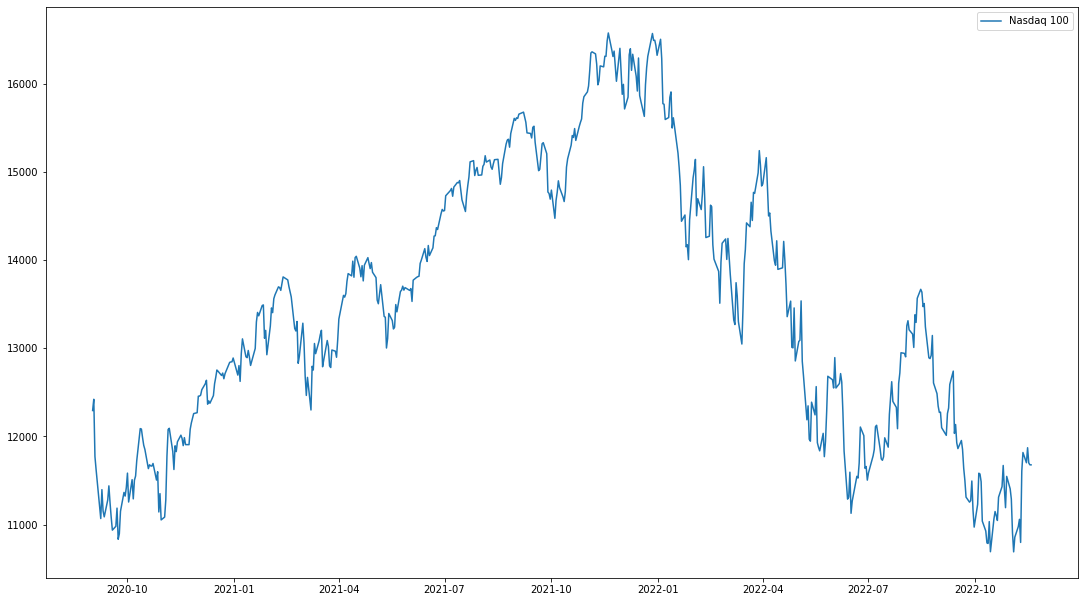

In [333]:
from matplotlib import pyplot
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
pyplot.plot(DF_Nasdaq['ds'],DF_Nasdaq["y"], label='Nasdaq 100')
pyplot.legend()
pyplot.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/6slq_ppw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/r8h3nd89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94025', 'data', 'file=/tmp/tmp9puoo3fo/6slq_ppw.json', 'init=/tmp/tmp9puoo3fo/r8h3nd89.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_models5bfn4yj/prophet_model-20221120132659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 101.147
MAPE: 0.862
MAE_Nasdaq =  101.14739006588715
MAPE_Nasdaq =  0.8615145731510987
RMSE_Nasdaq =  104.69679070484187
          ds          yhat    yhat_lower    yhat_upper
0 2022-11-14  11609.856679  10883.531257  12276.940227
1 2022-11-15  11725.601947  10970.311106  12425.273763
2 2022-11-16  11792.375573  11068.767770  12571.762469
3 2022-11-17  11788.937624  11074.986754  12575.020092
4 2022-11-18  11740.762380  10944.539819  12424.424048
           ds         y
0  2022-11-14  11700.94
1  2022-11-15  11871.15
2  2022-11-16  11699.09
3  2022-11-17  11676.86
4  2022-11-18  11677.02


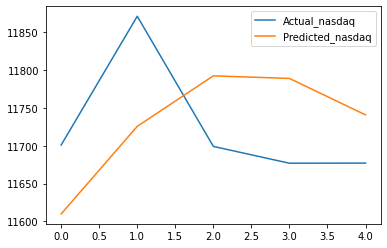

In [369]:
def ProhetModel_nasdaq(DF,CountryName):
  #train test split
  df2_test=DF[-5:]
  df2_train=DF[:-5]
  test_val = df2_test.copy()
  train_val = df2_train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.6,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 5,
                      seasonality_mode = 'additive',
                      weekly_seasonality=5,
                      daily_seasonality = 10,
                      yearly_seasonality = True,
                      interval_width=0.95)
  final_model.add_country_holidays(country_name=CountryName)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  #final_model.add_regressor('regressor', mode='additive')
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  #FutureDates_nasdaq=final_model.make_future_dataframe(periods=1)
  forecast = final_model.predict(test_val.drop("y", axis=1))
  mae = mean_absolute_error(test_val["y"], list(forecast["yhat"]))
  print('MAE: %.3f' % mae)
  mape = mean_absolute_percentage_error(test_val["y"], list(forecast["yhat"]))
  print('MAPE: %.3f' % mape)
  se = np.square(test_val["y"] -list(forecast["yhat"]))
  mse = np.mean(se)
  rmse = np.sqrt(mse)
  return mae, mape, forecast , test_val,rmse,train_val

mae_nasdaq, mape_nasdaq, forecast_nasdaq,test_val_nasdaq,rmse_nasdaq,train_val_nasdaq = ProhetModel_nasdaq(DF_Nasdaq,'US')
print('MAE_Nasdaq = ',mae_nasdaq)
print('MAPE_Nasdaq = ', mape_nasdaq)
print('RMSE_Nasdaq = ',rmse_nasdaq)
print(forecast_nasdaq[['ds','yhat','yhat_lower','yhat_upper']])
print(test_val_nasdaq)

from matplotlib import pyplot
pyplot.plot(test_val_nasdaq["y"], label='Actual_nasdaq')
pyplot.plot(list(forecast_nasdaq["yhat"]), label='Predicted_nasdaq')
pyplot.legend()
pyplot.show()

##Predicting(NASDAQ) for final data 21th Nov to 25th Nov

In [372]:
import dateutil
future = []
for i in range(3,8,1):
  future.append(DF_Nasdaq["ds"][DF_Nasdaq.shape[0]-1] + dateutil.relativedelta.relativedelta(days=i))
  
test_nasdaq = pd.DataFrame({"ds":future})
test_nasdaq.drop(test_nasdaq.index[3], inplace=True)
test_nasdaq = test_nasdaq.reset_index(drop=True)
print(test_nasdaq)

           ds
0  2022-11-21
1  2022-11-22
2  2022-11-23
3  2022-11-25


In [370]:
def ProhetModel_test_nasdaq(test,train,CountryName):
  #train test split
  test_val = test.copy()
  train_val = train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.6,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 5,
                      seasonality_mode = 'additive',
                      weekly_seasonality=5,
                      daily_seasonality = 10,
                      yearly_seasonality = True,
                      interval_width=0.95)
  final_model.add_country_holidays(country_name=CountryName)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  #final_model.add_regressor('regressor', mode='additive')
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  #FutureDates_nasdaq=final_model.make_future_dataframe(periods=1)
  #forecast = final_model.predict(test_val.drop("y", axis=1))
  forecast = final_model.predict(test_val)
  return forecast , test_val,train_val
train_nasdaq=DF_Nasdaq.copy()
final_forecast_nasdaq,final_test_val_nasdaq,final_train_val_nasdaq = ProhetModel_test_nasdaq(test_nasdaq,train_nasdaq,'UK')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/f327x1o4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/v9v1vxfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69377', 'data', 'file=/tmp/tmp9puoo3fo/f327x1o4.json', 'init=/tmp/tmp9puoo3fo/v9v1vxfa.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_modeliodz_3im/prophet_model-20221120132716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:27:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:27:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [371]:
print(final_forecast_nasdaq[['ds','yhat','yhat_lower','yhat_upper']])

          ds          yhat    yhat_lower    yhat_upper
0 2022-11-21  11751.804315  10996.709732  12444.915795
1 2022-11-22  11800.889696  11116.932340  12549.528707
2 2022-11-23  11824.891905  11081.122156  12561.198107
3 2022-11-25  11849.687751  11116.620986  12545.868979
